# MNIST Classification with Tensorflow

## Import modules, package, libraries

In [1]:
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

## These are the versions of the modules/packages/libraries used
### NOTE: This is to be run with a Python3 kernel
```
jupyter-notebook --version
5.4.0
python3 -m ipykernel --version
6.2.1
python3 -m pip freeze | grep -e numpy -e pandas -e matplotlib -e tensorflow
matplotlib==1.5.2
numpy==1.14.2
pandas==0.22.0
tensorflow==1.6.0
```

## Read in data and split into train and test sets

In [2]:
# Read in data from CSV files
train = pd.read_csv('ex4_train.csv', index_col=0)
test = pd.read_csv('ex4_test.csv', index_col=0)

# Split data into train and test sets
x_train, y_train = train.iloc[:, :-1].as_matrix(), train.iloc[:, -1].as_matrix()
x_test, y_test = test.iloc[:, :-1].as_matrix(), test.iloc[:, -1].as_matrix()

## Define constants & functions

In [3]:
NUM_ITERS=150
NUM_CLASSES = 10
HIDDEN_NEURONS_1 = 175
HIDDEN_NEURONS_2 = 150
LEARNING_RATE = 1e-6

def one_hot(y_train, y_test):
    """
        Create one hot encoding of class labels for both train and test data.
    """
    
    train_labels = tf.one_hot(indices=y_train, depth=NUM_CLASSES)
    test_labels = tf.one_hot(indices=y_test, depth=NUM_CLASSES)

    return train_labels, test_labels
    
def init_placeholders(x_train):
    """
        Create placeholders for the input data and the labels.
    """
    
    x_tensor = tf.placeholder(shape=(None, x_train.shape[1]), dtype=tf.float32, name='Input') 
    y_tensor = tf.placeholder(shape=(None, NUM_CLASSES), dtype=tf.int32, name='Labels')
    keep_prob = tf.placeholder(tf.float32)
    
    return x_tensor, y_tensor, keep_prob

def init_params(x_train):
    """
        Initialize the weights using the Xavier method and initialize biases to zero.
    """
    
    weight_shapes = [(x_train.shape[1], HIDDEN_NEURONS_1),
                 (HIDDEN_NEURONS_1, HIDDEN_NEURONS_2),
                 (HIDDEN_NEURONS_2, NUM_CLASSES)]
    
    bias_shapes = [(1, HIDDEN_NEURONS_1), (1, HIDDEN_NEURONS_2), (1, NUM_CLASSES)]
    
    W1, W2, W3 = [tf.get_variable(name='W{}'.format(i+1), shape=w, dtype=tf.float32,
                                  initializer=tf.contrib.layers.xavier_initializer(seed=1)) 
                  for i, w in enumerate(weight_shapes)]
    
    b1, b2, b3 = [tf.get_variable(name='b{}'.format(i+1), shape=b, dtype=tf.float32, 
                                  initializer=tf.zeros_initializer())
                  for i, b in enumerate(bias_shapes)]
    
    return (W1, W2, W3), (b1, b2, b3)

def forward(weights, biases, keep_prob):
    """
        Defines the forward pass computations.
    """
    
    W1, W2, W3 = weights
    b1, b2, b3 = biases
    
    a1 = tf.nn.relu(tf.add(tf.matmul(x_tensor, W1), b1), name='Hidden_1')
    a1 = tf.nn.dropout(a1, keep_prob, seed=1)
    a2 = tf.nn.relu(tf.add(tf.matmul(a1, W2), b2), name='Hidden_2')
    a1 = tf.nn.dropout(a2, keep_prob, seed=1)

    return tf.nn.sigmoid(tf.add(tf.matmul(a2, W3), b3), name='Output')

## Setup computation graph

In [4]:
# One-hot encode labels
one_hot_train, one_hot_test = one_hot(y_train, y_test)

# Initialize placeholders for input data and labels
x_tensor, y_tensor, keep_prob = init_placeholders(x_train)

# Initialize weights and biases
weights, biases = init_params(x_train)

# Define loss function
loss = tf.losses.softmax_cross_entropy(y_tensor, forward(weights, biases, keep_prob))

# Define optimizer
update = tf.train.AdamOptimizer(LEARNING_RATE).minimize(loss)

# Define prediction
predict = tf.argmax(forward(weights, biases, keep_prob=1.0), axis=1)

# Create initializer for graph variables
init = tf.global_variables_initializer()

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



## Train model

In [5]:
start = time.time()

with tf.Session() as sess: 
    sess.run(init)
       
    train_labels = sess.run(one_hot_train)
    test_labels = sess.run(one_hot_test)
    keep_probs = [x/10.0 for x in range(1, 10)]
    
    data = []
    
    print('\t\tTrain      Test\n')
    
    for k in keep_probs:
        
        print('keep_prob={}:'.format(k))
        
        for i in range(NUM_ITERS):
            for x, y in zip(x_train, train_labels):
                sess.run(update, feed_dict={x_tensor: x.reshape(1, -1), 
                                            y_tensor: y.reshape(1, -1),
                                            keep_prob: k})
        
            train_accuracy = np.mean(np.argmax(train_labels, axis=1) == 
                                     sess.run(predict, feed_dict={x_tensor: x_train.reshape(x_train.shape[0], -1), 
                                                                  y_tensor: train_labels}))
            test_accuracy = np.mean(np.argmax(test_labels, axis=1) == 
                                    sess.run(predict, feed_dict={x_tensor: x_test.reshape(x_test.shape[0], -1),
                                                                 y_tensor: test_labels}))
                        
            if (i+1) % 10 == 0:
                print('\t\t{:.2f}      {:.2f}'.format(100 * train_accuracy, 100 * test_accuracy))
                
        data.append((train_accuracy, test_accuracy))
       
print('Training took {} seconds.'.format(time.time() - start))

		Train      Test

keep_prob=0.1:
		18.71      18.60
		25.03      24.53
		34.43      33.47
		43.06      41.13
		51.94      49.00
		61.97      59.07
		68.14      66.27
		71.17      69.27
		73.40      70.73
		74.54      72.73
		75.29      74.13
		76.14      75.07
		76.89      75.73
		77.40      76.60
		77.63      77.13
keep_prob=0.2:
		78.26      77.60
		79.17      78.27
		79.94      78.73
		80.57      79.33
		80.94      79.93
		81.40      80.20
		81.54      80.13
		81.94      80.20
		82.29      80.53
		82.43      80.33
		82.69      80.33
		83.11      80.40
		83.34      80.53
		83.57      80.40
		83.83      80.80
keep_prob=0.3:
		83.89      81.40
		84.09      81.73
		84.51      82.07
		84.80      82.40
		85.09      82.87
		85.31      83.53
		85.66      83.87
		85.86      84.20
		86.31      84.33
		86.54      84.53
		86.83      84.93
		87.14      85.27
		87.26      85.67
		87.49      86.00
		87.66      86.27
keep_prob=0.4:
		87.89      86.73
		88.26      87.00
		88.49      87.00
		88.80  

## Plot test accuracy over dropout's "keep_prob" ratio

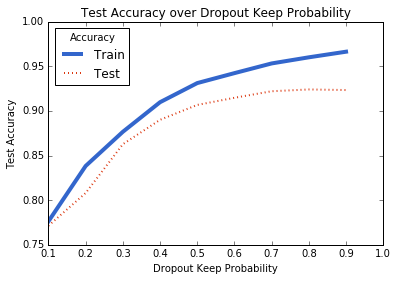

In [6]:
plt.title('Test Accuracy over Dropout Keep Probability')
plt.xlabel('Dropout Keep Probability')
plt.ylabel('Test Accuracy')
lines = [
    plt.plot(keep_probs, [d[0] for d in data], color='#3366CC', linestyle='-', linewidth=4)[0],
    plt.plot(keep_probs, [d[1] for d in data], color='#DC3912', linestyle=':', linewidth=2)[0]
]
plt.legend(lines, ['Train', 'Test'], title='Accuracy', bbox_to_anchor=(0.26, 1))